# 1 Using the demandlib to create heat demand profiles

![Image](pics/demandlib.png)

See the section [model description](http://demandlib.readthedocs.io/en/latest/description.html#bdew) in the documentation on readthedocs.

Have a look at the github repository at: https://github.com/oemof/demandlib  


Heat profiles are created according to the approach described in the [BDEW guideline](https://www.enwg-veroeffentlichungen.de/badtoelz/Netze/Gasnetz/Netzbeschreibung/LF-Abwicklung-von-Standardlastprofilen-Gas-20110630-final.pdf).

The method was originally established this [PhD Thesis at TU Munich](https://mediatum.ub.tum.de/doc/601557/601557.pdf).

Further sources, explaining the age classification of buildings (Baualtersklassen) and influence of wind:
[1](https://www.stadtwerke-schkeuditz.de/files/pageflip/praxisinformationpslpgas/pdf/phpwHngCb20130228171455.pdf)
[2](https://www.eko-netz.de/files/eko-netz/download/3.5_standardlastprofile_bgw_information_lastprofile.pdf)

### Import necessary modules and configure matplotlib

In [82]:
import pandas as pd
import demandlib.bdew as bdew
import matplotlib
import matplotlib.pyplot as plt
import datetime
# import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20.0, 7.0]

###  Read example temperature series

In [83]:
filename = 'example_data.csv'
temperature = pd.read_csv(filename)["temperature"]

### Get holidays for specified year and country

In [84]:
# The following dictionary is create by "workalendar"
# pip3 install workalendar
# >>> from workalendar.europe import Germany
# >>> cal = Germany()
# >>> holidays = dict(cal.holidays(2010))

from workalendar.europe import Germany
cal = Germany()
holidays = dict(cal.holidays(2010))
holidays

{datetime.date(2010, 1, 1): 'New year',
 datetime.date(2010, 4, 2): 'Good Friday',
 datetime.date(2010, 4, 5): 'Easter Monday',
 datetime.date(2010, 5, 1): 'Labour Day',
 datetime.date(2010, 5, 13): 'Ascension Thursday',
 datetime.date(2010, 5, 24): 'Whit Monday',
 datetime.date(2010, 10, 3): 'Day of German Unity',
 datetime.date(2010, 12, 25): 'Christmas Day',
 datetime.date(2010, 12, 26): 'Second Christmas Day'}

In [85]:
holidays = {
    datetime.date(2010, 5, 24): 'Whit Monday',
    datetime.date(2010, 4, 5): 'Easter Monday',
    datetime.date(2010, 5, 13): 'Ascension Thursday',
    datetime.date(2010, 1, 1): 'New year',
    datetime.date(2010, 10, 3): 'Day of German Unity',
    datetime.date(2010, 12, 25): 'Christmas Day',
    datetime.date(2010, 5, 1): 'Labour Day',
    datetime.date(2010, 4, 2): 'Good Friday',
    datetime.date(2010, 12, 26): 'Second Christmas Day'}

In [86]:
from .tools import add_weekdays2df
new_df = add_weekdays2df(new_df, holidays=holidays, holiday_is_sunday=True)

SystemError: Parent module '' not loaded, cannot perform relative import

### Create demand series for 2010

We need

* `df_index` - the timeindex
* `temperature` - a timeseries of daily mean temperatures for the location at 2 m above the ground.
* `shlp_type` - possible types are:
        
    **EFH**: Einfamilienhaus (single family house)  
    **MFH**: Mehrfamilienhaus (multi family house)  
    **GMK**: Metall und Kfz (metal and automotive)  
    **GHA**: Einzel- und Großhandel (retail and wholesale)  
    **GKO**: Gebietskörperschaften, Kreditinstitute und Versicherungen (Local authorities, credit institutions and insurance companies)  
    **GBD**: sonstige betriebliche Dienstleistung (other operational services)  
    **GGA**: Gaststätten (restaurants)  
    **GBH**: Beherbergung (accommodation)  
    **GWA**: Wäschereien, chemische Reinigungen (laundries, dry cleaning)  
    **GGB**: Gartenbau (horticulture)  
    **GBA**: Backstube (bakery)  
    **GPD**: Papier und Druck (paper and printing)  
    **GMF**: haushaltsähnliche Gewerbebetriebe (household-like business enterprises)  
    **GHD**: Summenlastprofil Gewerbe/Handel/Dienstleistungen (Total load profile Business/Commerce/Services)  
    
        
* `building_class` - class of building according to BDEW classification. Only for 'EFH' and 'MFH'. It reflects the share of buildings older than 1979. Possible numbers are: 
        1 - 11

The following table (from https://www.eko-netz.de/files/eko-netz/download/3.5_standardlastprofile_bgw_information_lastprofile.pdf) specifies which class belongs to which share. Class 11 is an overall class assumed for Germany

![](pics/baualtersklassen_.png)

        
* `wind_class` - wind classification for building location:
        0=not windy or 1=windy
* `incl_ww` - include heat demand for warm water, `True` by default, if not, parameter D is set to zero.
* `annual_heat_demand` - as it says, this is the total annual heat demand.

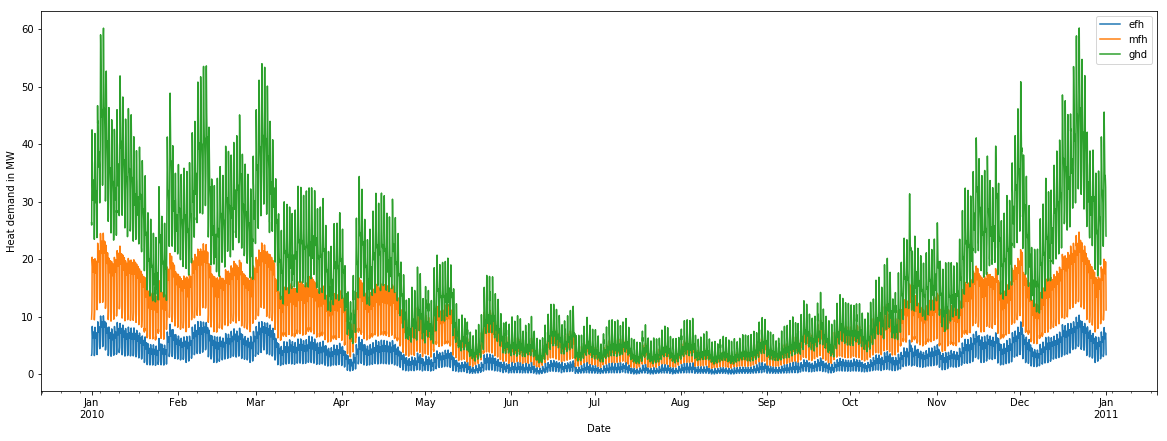

In [87]:
# create a DataFrame to hold the timeseries
demand = pd.DataFrame(
    index=pd.date_range(pd.datetime(2010, 1, 1, 0),
                        periods=8760, freq='H'))


# Single family house (efh: Einfamilienhaus)
demand['efh'] = bdew.HeatBuilding(
    demand.index, holidays=holidays, temperature=temperature,
    shlp_type='EFH',
    building_class=1, wind_class=1, annual_heat_demand=25000,
    name='EFH').get_bdew_profile()

# Multi family house (mfh: Mehrfamilienhaus)
demand['mfh'] = bdew.HeatBuilding(
    demand.index, holidays=holidays, temperature=temperature,
    shlp_type='MFH',
    building_class=2, wind_class=0, annual_heat_demand=80000,
    name='MFH').get_bdew_profile()

# Industry, trade, service (ghd: Gewerbe, Handel, Dienstleistung)
demand['ghd'] = bdew.HeatBuilding(
    demand.index, holidays=holidays, temperature=temperature,
    shlp_type='ghd', wind_class=0, annual_heat_demand=140000,
    name='ghd').get_bdew_profile()

# Plot demand of building
ax = demand.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Heat demand in MW")
plt.show()

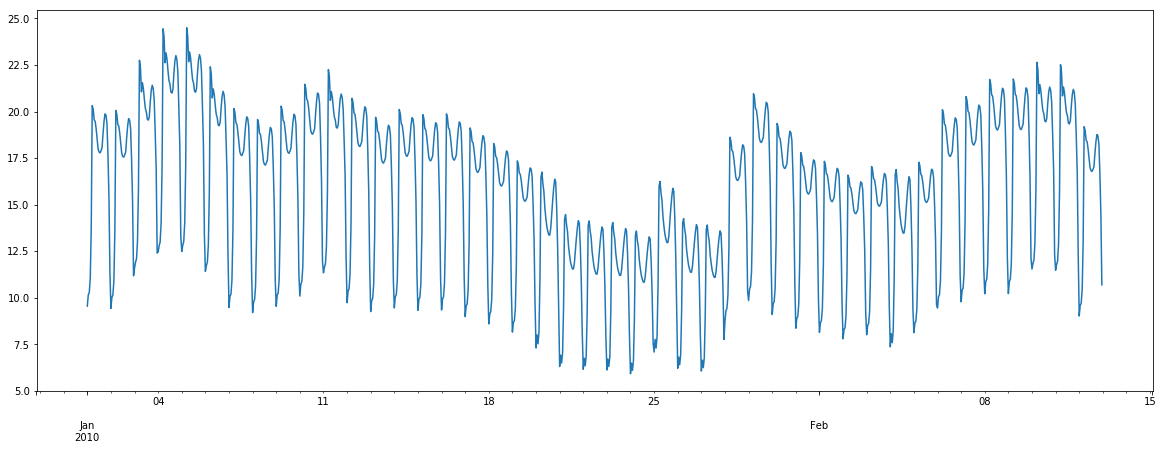

In [88]:
demand['2010-01-01':'2010-02-12']['mfh'].plot()

Where to get the necessary data from?

* Temperature information - Marcus https://www.scribd.com/document/345725803/The-state-of-weather-data-infrastructure-white-paper
* Building types: In Germany, there is data from Zensus - Marcus
* Annual demand - Marcus
* How to estimate if a the region is windy or not? The documentation does not provide a clear guideline. As a rough estimate, it proposes to classify the north of Germany as windy, the rest not.

How to handle industry demand?
How big is the contribution of cooking gas consumption?
References to validate:

# 2 Compare with DIW data

Source: https://zenodo.org/record/1044463

Index(['hour', 'DH_DE_Berlin', 'DH_DE_Dresden', 'DH_DE_Gelsenkirchen',
       'DH_DE_Hamburg', 'DH_DE_Mannheim', 'DH_DE_Muenchen', 'DH_DE_Rem',
       'DH_DE_Ind', 'DH_DE_Neckar', 'DH_DE_Nuernberg', 'DH_DE_Ruhr',
       'DH_DE_Saar'],
      dtype='object')


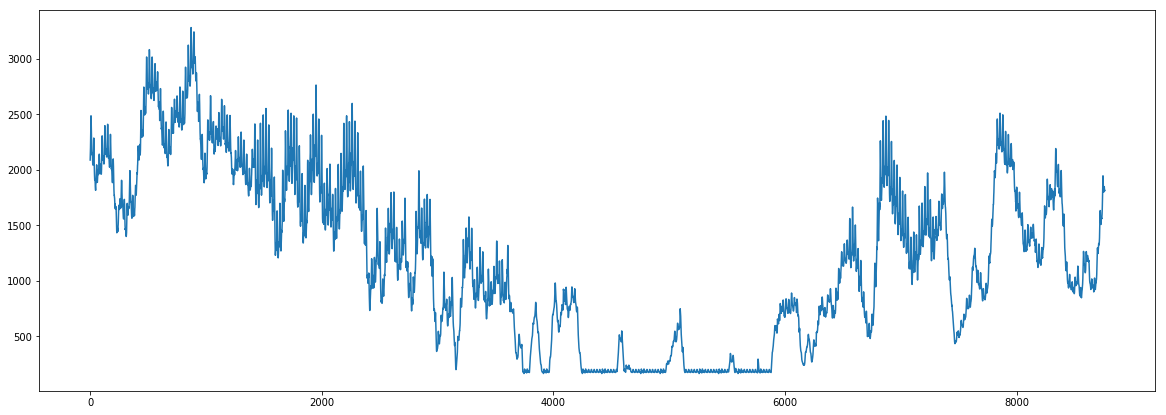

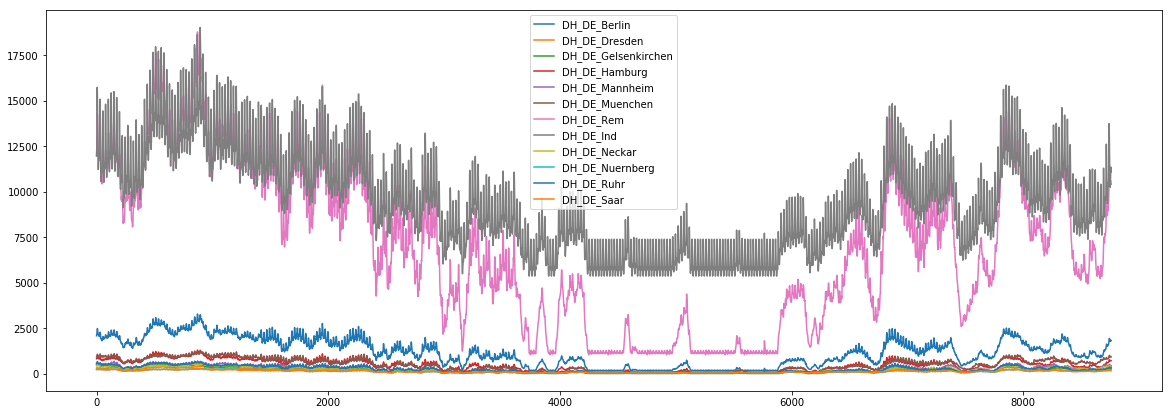

In [108]:
diw_demand = pd.read_csv('data/DHN_demand_germany_.csv', header=4, delimiter=';')
print(diw_demand.columns)
diw_demand['DH_DE_Berlin'].plot()
diw_demand.plot()

# 3 Simple Heating degree day method

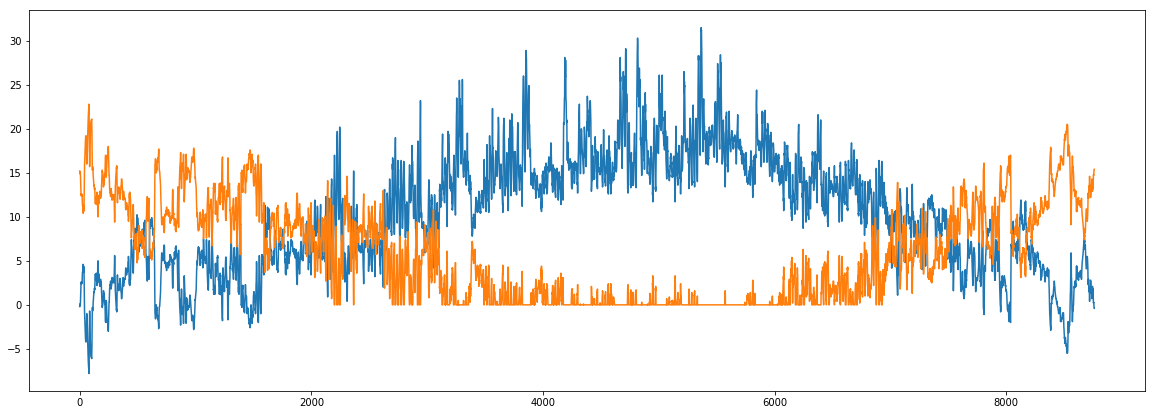

In [164]:
temperature = pd.read_csv(filename)["temperature"]
temperature.plot()
hdd_demand = -temperature.copy() + 15
(hdd_demand.loc[temperature>15]) = 0
hdd_demand.plot()

###### 